In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output


import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

In [2]:
env_name = "halfcheetah"  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = "generalized"  # @param ['generalized', 'positional', 'spring']

env = envs.get_environment(env_name=env_name, backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

2023-10-23 11:05:02.380789: W external/xla/xla/service/gpu/nvptx_compiler.cc:673] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Training

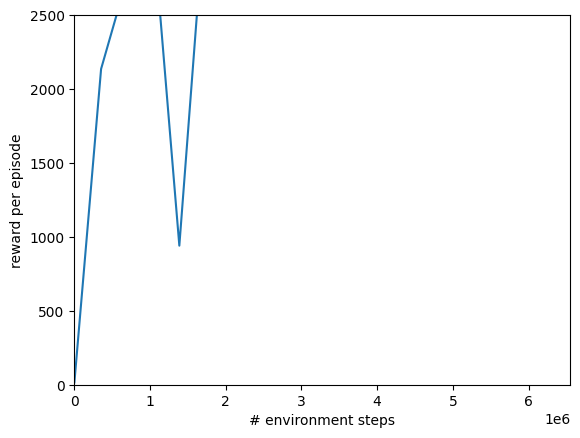

In [3]:
# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
    "inverted_pendulum": functools.partial(
        ppo.train,
        num_timesteps=2_000_000,
        num_evals=20,
        reward_scaling=10,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=1,
        unroll_length=5,
        num_minibatches=32,
        num_updates_per_batch=4,
        discounting=0.97,
        learning_rate=3e-4,
        entropy_cost=1e-2,
        num_envs=2048,
        batch_size=1024,
        seed=1,
    ),
    "inverted_double_pendulum": functools.partial(
        ppo.train,
        num_timesteps=20_000_000,
        num_evals=20,
        reward_scaling=10,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=1,
        unroll_length=5,
        num_minibatches=32,
        num_updates_per_batch=4,
        discounting=0.97,
        learning_rate=3e-4,
        entropy_cost=1e-2,
        num_envs=2048,
        batch_size=1024,
        seed=1,
    ),
    "ant": functools.partial(
        ppo.train,
        num_timesteps=50_000_000,
        num_evals=10,
        reward_scaling=10,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=1,
        unroll_length=5,
        num_minibatches=32,
        num_updates_per_batch=4,
        discounting=0.97,
        learning_rate=3e-4,
        entropy_cost=1e-2,
        num_envs=4096,
        batch_size=2048,
        seed=1,
    ),
    "humanoid": functools.partial(
        ppo.train,
        num_timesteps=50_000_000,
        num_evals=10,
        reward_scaling=0.1,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=1,
        unroll_length=10,
        num_minibatches=32,
        num_updates_per_batch=8,
        discounting=0.97,
        learning_rate=3e-4,
        entropy_cost=1e-3,
        num_envs=2048,
        batch_size=1024,
        seed=1,
    ),
    "reacher": functools.partial(
        ppo.train,
        num_timesteps=50_000_000,
        num_evals=20,
        reward_scaling=5,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=4,
        unroll_length=50,
        num_minibatches=32,
        num_updates_per_batch=8,
        discounting=0.95,
        learning_rate=3e-4,
        entropy_cost=1e-3,
        num_envs=2048,
        batch_size=256,
        max_devices_per_host=8,
        seed=1,
    ),
    "humanoidstandup": functools.partial(
        ppo.train,
        num_timesteps=100_000_000,
        num_evals=20,
        reward_scaling=0.1,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=1,
        unroll_length=15,
        num_minibatches=32,
        num_updates_per_batch=8,
        discounting=0.97,
        learning_rate=6e-4,
        entropy_cost=1e-2,
        num_envs=2048,
        batch_size=1024,
        seed=1,
    ),
    "hopper": functools.partial(
        sac.train,
        num_timesteps=6_553_600,
        num_evals=20,
        reward_scaling=30,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=1,
        discounting=0.997,
        learning_rate=6e-4,
        num_envs=128,
        batch_size=512,
        grad_updates_per_step=64,
        max_devices_per_host=1,
        max_replay_size=1048576,
        min_replay_size=8192,
        seed=1,
    ),
    "walker2d": functools.partial(
        sac.train,
        num_timesteps=7_864_320,
        num_evals=20,
        reward_scaling=5,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=1,
        discounting=0.997,
        learning_rate=6e-4,
        num_envs=128,
        batch_size=128,
        grad_updates_per_step=32,
        max_devices_per_host=1,
        max_replay_size=1048576,
        min_replay_size=8192,
        seed=1,
    ),
    "halfcheetah": functools.partial(
        ppo.train,
        num_timesteps=50_000_000,
        num_evals=20,
        reward_scaling=1,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=1,
        unroll_length=20,
        num_minibatches=32,
        num_updates_per_batch=8,
        discounting=0.95,
        learning_rate=3e-4,
        entropy_cost=0.001,
        num_envs=2048,
        batch_size=512,
        seed=3,
    ),
    "pusher": functools.partial(
        ppo.train,
        num_timesteps=50_000_000,
        num_evals=20,
        reward_scaling=5,
        episode_length=1000,
        normalize_observations=True,
        action_repeat=1,
        unroll_length=30,
        num_minibatches=16,
        num_updates_per_batch=8,
        discounting=0.95,
        learning_rate=3e-4,
        entropy_cost=1e-2,
        num_envs=2048,
        batch_size=512,
        seed=3,
    ),
}[env_name]


max_y = {
    "ant": 8000,
    "halfcheetah": 8000,
    "hopper": 2500,
    "humanoid": 13000,
    "humanoidstandup": 75_000,
    "reacher": 5,
    "walker2d": 5000,
    "pusher": 0,
}[env_name]
min_y = {"reacher": -100, "pusher": -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]


def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics["eval/episode_reward"])
    clear_output(wait=True)
    plt.xlim([0, train_fn.keywords["num_timesteps"]])
    plt.ylim([min_y, max_y])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.plot(xdata, ydata)
    plt.show()


make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)
inference_fn = make_inference_fn(params)

print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

# Inference

In [ ]:
# create an env with auto-reset
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_env_step(state, act)

HTML(html.render(env.sys.replace(dt=env.dt), rollout))